### Abstract. 

Classification of remote sensing multichannel images remains a challenging task due to the influence of several factors, including image compression and noise. In this study, we replicate and expand upon the previously conducted research on the classification of compressed noisy three-channel images by evaluating the potential of a new classifier based on the combination of Local Binary Patterns (LBP), color features, and the XGBoost algorithm. Specifically, we investigate the following factors: 1) the effect of residual noise after applying lossy compression to noisy images; 2) the impact of training a classifier on data that matches the quality conditions of the target compressed images; and 3) the benefits of post-filtering to improve the quality of compressed images before classification. Our experiments, conducted on Sentinel data with artificially added additive white Gaussian noise, demonstrate that the proposed LBP+Color+XGBoost classifier achieves competitive performance in handling noisy and compressed images. We confirm the importance of aligning classifier training with the quality conditions of the target images and highlight scenarios in which post-filtering can further enhance classification accuracy. These findings provide insights into the robustness of the LBP+Color+XGBoost pipeline for remote sensing data tasks involving challenging noise and compression conditions.

### Action Plan (in English)

1. **Develop a function to add Gaussian noise:**  
   Create a function that simulates the addition of Additive White Gaussian Noise (AWGN) to multichannel images.  

2. **Develop a function for image compression:**  
   Implement a function to compress images using lossy compression methods, such as JPEG or similar, with adjustable compression ratio parameters.

3. **Evaluate compressed images using PSNR:**  
   Develop a function to calculate the **Peak Signal-to-Noise Ratio (PSNR)** for compressed images. Use this function to identify the optimal compression ratio that yields the maximum PSNR value.

4. **Pixel-wise classification using the new classifier:**  
   Once the optimal compression point is determined, perform pixel-wise classification on the images using the proposed classifier **LBP+Color+XGBoost**. Analyze the classification results and assess the effectiveness of the new approach.

# 8 May discussion

Для перевірки зробити grayscale та порахувати PSNR, також 100
Також R G B - PSNR
Наступного разу спільна сесія, підготувати енв.



### Import libraries

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import paramiko
import os

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
def add_awgn_noise(image, sigma_squared):
    """
    Додає Additive White Gaussian Noise (AWGN) до зображення.
    
    :param image: Вхідне зображення у форматі NumPy масиву (RGB).
    :param sigma_squared: Дисперсія шуму (sigma^2).
    :return: Зображення з доданим шумом.
    """
    # Переконайтеся, що вхідне зображення є дійсним NumPy масивом
    if not isinstance(image, np.ndarray):
        raise ValueError("Вхідне зображення повинно бути NumPy масивом.")
    
    # Переконайтеся, що дисперсія шуму (sigma^2) є невід’ємною
    if sigma_squared < 0:
        raise ValueError("Дисперсія шуму (sigma^2) повинна бути невід’ємним числом.")
    
    # Обчислення стандартного відхилення (sigma) як sqrt(sigma^2)
    sigma = np.sqrt(sigma_squared)
    
    # Генерування шуму з нормальним розподілом
    noise = np.random.normal(0, sigma, image.shape).astype(np.float32)
    
    # Додавання шуму до зображення
    noisy_image = image.astype(np.float32) + noise
    
    # Обмеження значень пікселів у діапазоні [0, 255]
    noisy_image = np.clip(noisy_image, 0, 255)
    
    # Перетворення зображення назад до його оригінального типу даних
    return noisy_image.astype(image.dtype)

In [5]:
# Function to upload files to the server
def upload_to_server(local_path, remote_path, server_ip, username, password):
    """
    Upload a file to the server via SFTP.
    """
    print(f"Uploading {local_path} to {remote_path} on server...")
    ssh = paramiko.SSHClient()
    ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    ssh.connect(server_ip, username=username, password=password)
    ftp_client = ssh.open_sftp()
    ftp_client.put(local_path, remote_path)
    ftp_client.close()
    ssh.close()

In [6]:
def download_from_server(remote_path, local_path, server_ip, username, password):
    """
    Download a file from the server to the local machine via SFTP.

    :param remote_path: Path to the file on the server.
    :param local_path: Path to save the file locally on the machine.
    :param server_ip: IP address of the server.
    :param username: Username for SSH access to the server.
    :param password: Password for SSH access to the server.
    """
    import paramiko
    print(f"Downloading {remote_path} from server to {local_path}...")
    ssh = paramiko.SSHClient()
    ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    ssh.connect(server_ip, username=username, password=password)
    ftp_client = ssh.open_sftp()
    ftp_client.get(remote_path, local_path)  # Use get() to download file from server
    ftp_client.close()
    ssh.close()

In [7]:
def calculate_psnr(original, noisy):
    """
    Calculates PSNR (Peak Signal-to-Noise Ratio) using OpenCV's built-in method.

    :param original: Original image as a NumPy array.
    :param noisy: Noisy image as a NumPy array.
    :return: PSNR value in decibels (float). Returns `inf` if the images are identical.
    """
    # Verify that the dimensions of the images match
    if original.shape != noisy.shape:
        raise ValueError("Original and noisy images must have the same shape.")

    # Use OpenCV's PSNR function
    psnr = cv2.PSNR(original, noisy)
    return psnr

In [8]:
def calculate_psnr_grayscale(original, noisy):
    """
    Calculates PSNR (Peak Signal-to-Noise Ratio) for grayscale versions of the images.

    :param original: Original image as a NumPy array (RGB/BGR).
    :param noisy: Noisy image as a NumPy array (RGB/BGR).
    :return: PSNR value in decibels (float). Returns `inf` if the images are identical.
    """
    # Verify that the dimensions of the images match
    if original.shape != noisy.shape:
        raise ValueError("Original and noisy images must have the same shape.")
    
    # Convert images to grayscale
    original_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)  # Convert original to grayscale
    noisy_gray = cv2.cvtColor(noisy, cv2.COLOR_BGR2GRAY)        # Convert noisy to grayscale

    # Use OpenCV's PSNR function
    psnr = cv2.PSNR(original_gray, noisy_gray)
    return psnr

In [9]:
def calculate_psnr_per_channel(original, noisy):
    """
    Обчислює PSNR (Peak Signal-to-Noise Ratio) для кожного каналу окремо (R, G, B).

    Parameters:
        original: Оригінальне зображення (RGB).
        noisy: Зображення для порівняння (RGB).

    Returns:
        psnr_values: Словник з PSNR для кожного каналу (R, G, B).
    """
    # Розділяємо зображення на канали
    r1, g1, b1 = cv2.split(original)  # Оригінальне зображення
    r2, g2, b2 = cv2.split(noisy)    # Змінене зображення
    
    # Ініціалізуємо словник для збереження PSNR значень
    psnr_values = {}

    # Функція розрахунку PSNR для одного каналу
    def calculate_channel_psnr(channel1, channel2):
        mse = np.mean((channel1 - channel2) ** 2)
        if mse == 0:
            return float('inf')  # Ідеальна відповідність
        max_pixel = 255.0
        return 20 * np.log10(max_pixel / np.sqrt(mse))
    
    # Розраховуємо PSNR для кожного каналу
    psnr_values['R'] = calculate_channel_psnr(r1, r2)
    psnr_values['G'] = calculate_channel_psnr(g1, g2)
    psnr_values['B'] = calculate_channel_psnr(b1, b2)

    return psnr_values

Перевірка порядку кольорових каналів (R, G, B): Можна порівняти середнє значення кожного каналу оригінального та декодованого зображення. Це допоможе визначити, чи не переплутано канали.

In [10]:
def compare_channel_order(original, decompressed):
    original_mean = cv2.mean(original)
    decompressed_mean = cv2.mean(decompressed)
    print(f"Original channel means: {original_mean}")
    print(f"Decompressed channel means: {decompressed_mean}")

Перевірка кореляції каналів: Використання кореляції між каналами оригінального та декодованого зображення (за кожним каналом окремо) дозволить переконатись, що канали правильно порівнюються.

In [26]:
def check_channel_correlation(original, decompressed):
    """
    Compare the correlation of color channels between the original and decompressed images.
    Also visualize the R, G, B channels with their respective colors for both images side by side.

    :param original: Original image (NumPy array).
    :param decompressed: Decompressed image (NumPy array).
    """
    # Split the channels for the original and decompressed images
    r1, g1, b1 = cv2.split(original)  # Channels of the original image
    r2, g2, b2 = cv2.split(decompressed)  # Channels of the decompressed image

    # Calculate correlations for each channel
    correlation_r = np.corrcoef(r1.flatten(), r2.flatten())[0, 1]
    correlation_g = np.corrcoef(g1.flatten(), g2.flatten())[0, 1]
    correlation_b = np.corrcoef(b1.flatten(), b2.flatten())[0, 1]
    
    # Print correlations
    print(f"Correlation between original and decompressed channels:")
    print(f"R-channel: {correlation_r:.2f}")
    print(f"G-channel: {correlation_g:.2f}")
    print(f"B-channel: {correlation_b:.2f}")

    # Create colored channels for visualization
    original_r = cv2.merge([r1, np.zeros_like(r1), np.zeros_like(r1)])  # Red channel in red
    original_g = cv2.merge([np.zeros_like(g1), g1, np.zeros_like(g1)])  # Green channel in green
    original_b = cv2.merge([np.zeros_like(b1), np.zeros_like(b1), b1])  # Blue channel in blue

    decompressed_r = cv2.merge([r2, np.zeros_like(r2), np.zeros_like(r2)])  # Red channel in red
    decompressed_g = cv2.merge([np.zeros_like(g2), g2, np.zeros_like(g2)])  # Green channel in green
    decompressed_b = cv2.merge([np.zeros_like(b2), np.zeros_like(b2), b2])  # Blue channel in blue

    # Visualize the channels using matplotlib
    fig, axes = plt.subplots(3, 2, figsize=(12, 8))
    fig.suptitle("Channel Comparison: Original vs. Decompressed", fontsize=16)

    # Plot each channel for original and decompressed images
    axes[0, 0].imshow(cv2.cvtColor(original_r, cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title("Original R-Channel")
    axes[0, 0].axis('off')

    axes[0, 1].imshow(cv2.cvtColor(decompressed_r, cv2.COLOR_BGR2RGB))
    axes[0, 1].set_title("Decompressed R-Channel")
    axes[0, 1].axis('off')

    axes[1, 0].imshow(cv2.cvtColor(original_g, cv2.COLOR_BGR2RGB))
    axes[1, 0].set_title("Original G-Channel")
    axes[1, 0].axis('off')

    axes[1, 1].imshow(cv2.cvtColor(decompressed_g, cv2.COLOR_BGR2RGB))
    axes[1, 1].set_title("Decompressed G-Channel")
    axes[1, 1].axis('off')

    axes[2, 0].imshow(cv2.cvtColor(original_b, cv2.COLOR_BGR2RGB))
    axes[2, 0].set_title("Original B-Channel")
    axes[2, 0].axis('off')

    axes[2, 1].imshow(cv2.cvtColor(decompressed_b, cv2.COLOR_BGR2RGB))
    axes[2, 1].set_title("Decompressed B-Channel")
    axes[2, 1].axis('off')

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

### Setting Up BGP Compression

There is no Python library that supports BGP directly, so we will use the command-line utilities `bpgenc` (for compression) and `bpgdec` (for decoding). We can integrate the calls to these utilities into Python using the `subprocess` library.

In progress ...

In [13]:
def run_bpg_on_server(input_path, output_bpg_path, output_png_path, quality, server_ip, username, password):
    """
    Perform BPG compression and decompression entirely on the server using SSH.

    :param input_path: Path to the input image file on the server.
    :param output_bpg_path: Path for the compressed BPG file on the server.
    :param output_png_path: Path for the decompressed PNG file on the server.
    :param quality: Quality parameter for BPG compression (1-51).
    :param server_ip: IP address of the server.
    :param username: Username for SSH access to the server.
    :param password: Password for SSH access to the server.
    """
    import paramiko

    # Connect to the server via SSH
    ssh = paramiko.SSHClient()
    ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    ssh.connect(server_ip, username=username, password=password)

    # Step 1: Ensure input BMP exists
    print(f"Checking for input file on the server: {input_path}")
    check_input_cmd = f"ls {input_path}"
    stdin, stdout, stderr = ssh.exec_command(check_input_cmd)
    stdout_result = stdout.read().decode().strip()
    stderr_result = stderr.read().decode().strip()
    if "No such file" in stderr_result:
        raise FileNotFoundError(f"Input BMP file not found: {input_path}")

    # Step 2: Convert BMP to PNG
    png_path = input_path.replace(".bmp", ".png")
    print(f"Converting BMP to PNG on server: {input_path} -> {png_path}")
    convert_cmd = f"convert {input_path} {png_path}"
    stdin, stdout, stderr = ssh.exec_command(convert_cmd)
    stdout_result = stdout.read().decode().strip()
    stderr_result = stderr.read().decode().strip()
    if stderr_result:
        raise RuntimeError(f"Error converting BMP to PNG: {stderr_result}")
    else:
        print(f"Convert Output: {stdout_result.strip()}")

    # Step 3: Ensure PNG exists
    print(f"Checking for converted PNG: {png_path}")
    check_png_cmd = f"ls {png_path}"
    stdin, stdout, stderr = ssh.exec_command(check_png_cmd)
    stdout_result = stdout.read().decode().strip()
    stderr_result = stderr.read().decode().strip()
    if "No such file" in stderr_result:
        raise FileNotFoundError(f"Converted PNG file not found on server: {png_path}")
    print(f"PNG file found on server: {png_path}")

    # Step 4: Perform BPG compression
    print(f"Compressing PNG to BPG: {png_path} -> {output_bpg_path}")
    bpgenc_cmd = f"bpgenc -o {output_bpg_path} -q {quality} {png_path}"
    stdin, stdout, stderr = ssh.exec_command(bpgenc_cmd)
    stderr_result = stderr.read().decode().strip()
    if stderr_result:
        raise RuntimeError(f"BPG Compression Error: {stderr_result}")

    # Step 5: Perform BPG decompression
    print(f"Decompressing BPG to PNG: {output_bpg_path} -> {output_png_path}")
    bpgdec_cmd = f"bpgdec -o {output_png_path} {output_bpg_path}"
    stdin, stdout, stderr = ssh.exec_command(bpgdec_cmd)
    stderr_result = stderr.read().decode().strip()
    if stderr_result:
        raise RuntimeError(f"BPG Decompression Error: {stderr_result}")
    
    ssh.close()

In [14]:
def display_multiple_images(images, titles, cmap=None):
    """
    Displays multiple images in a table layout in a Jupyter Notebook.

    :param images: List of images as NumPy arrays.
    :param titles: List of titles for the images.
    :param cmap: Color map; use 'gray' for monochrome images.
    """
    plt.figure(figsize=(15, 10))
    n = len(images)
    for i in range(n):
        plt.subplot(1, n, i + 1)
        if len(images[i].shape) == 2:  # Grayscale
            plt.imshow(images[i], cmap=cmap or 'gray')
        elif len(images[i].shape) == 3 and images[i].shape[2] == 3:  # RGB
            plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
        else:
            raise ValueError("Unsupported image shape.")
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [38]:
### Validate PSNR for compresses image

### Here we check bmp with noise

local_shared_folder = "/Users/Maksym_Rybnytskyi/Library/CloudStorage/OneDrive-EPAM/Університет/Аспірантура/PhD/Repositories/xgboost-classifiers/Images/sentinel/SS1"  # Local path on MacBook
noisy_shared_folder = "/Users/Maksym_Rybnytskyi/Documents/UTMShare"
image1_path_local = os.path.join(local_shared_folder, "SS1.bmp")
original_image = cv2.imread(image1_path_local, cv2.IMREAD_COLOR)
noisy_path_local = os.path.join(noisy_shared_folder, "noisy_sigma_100_img_1.bmp")
noisy_image = cv2.imread(noisy_path_local, cv2.IMREAD_COLOR)
psnr = calculate_psnr(original_image, noisy_image)

print(f'PSNR for noisy image: {psnr}')

### Here we check decompresssed png with noise we get in script

local_shared_folder = "/Users/Maksym_Rybnytskyi/Library/CloudStorage/OneDrive-EPAM/Університет/Аспірантура/PhD/Repositories/xgboost-classifiers/Images/sentinel/SS1"  # Local path on MacBook
noisy_shared_folder = "/Users/Maksym_Rybnytskyi/Documents/UTMShare"
image1_path_local = os.path.join(local_shared_folder, "SS1.bmp")
original_image = cv2.imread(image1_path_local, cv2.IMREAD_COLOR)
noisy_path_local = os.path.join(noisy_shared_folder, "decompressed_q1_sigma_100_img_1.png")
noisy_image = cv2.imread(noisy_path_local, cv2.IMREAD_COLOR)
psnr = calculate_psnr(original_image, noisy_image)

print(f'PSNR for decompressed noisy image: {psnr}')

### Here we check decompresssed png with noise we get manually

local_shared_folder = "/Users/Maksym_Rybnytskyi/Library/CloudStorage/OneDrive-EPAM/Університет/Аспірантура/PhD/Repositories/xgboost-classifiers/Images/sentinel/SS1"  # Local path on MacBook
noisy_shared_folder = "/Users/Maksym_Rybnytskyi/Documents"
image1_path_local = os.path.join(local_shared_folder, "SS1.bmp")
original_image = cv2.imread(image1_path_local, cv2.IMREAD_COLOR)
noisy_path_local = os.path.join(noisy_shared_folder, "decompressed.png")
noisy_image = cv2.imread(noisy_path_local, cv2.IMREAD_COLOR)
psnr = calculate_psnr(original_image, noisy_image)

print(f'PSNR for decompressed noisy image: {psnr}')

PSNR for noisy image: 28.727163142003988
PSNR for decompressed noisy image: 30.997757200775567
PSNR for decompressed noisy image: 30.997757200775567


In [32]:
### Validate PSNR calculation. It should be 33.8

local_shared_folder = "/Users/Maksym_Rybnytskyi/Library/CloudStorage/OneDrive-EPAM/Університет/Аспірантура/PhD/Repositories/xgboost-classifiers/Images/sentinel/SS1"  # Local path on MacBook
image1_path_local = os.path.join(local_shared_folder, "SS1.bmp")
original_image = cv2.imread(image1_path_local, cv2.IMREAD_COLOR)
noisy_path_local = os.path.join(local_shared_folder, "SS1_PSNR_33.8.bmp")
noisy_image = cv2.imread(noisy_path_local, cv2.IMREAD_COLOR)
psnr = calculate_psnr(original_image, noisy_image)

print(psnr)

33.82459311193631


Uploading /Users/Maksym_Rybnytskyi/Documents/UTMShare/SS1.bmp to server at /home/max/Documents/SS1.bmp...
Uploading /Users/Maksym_Rybnytskyi/Documents/UTMShare/SS1.bmp to /home/max/Documents/SS1.bmp on server...
Uploading /Users/Maksym_Rybnytskyi/Documents/UTMShare/SS2.bmp to server at /home/max/Documents/SS2.bmp...
Uploading /Users/Maksym_Rybnytskyi/Documents/UTMShare/SS2.bmp to /home/max/Documents/SS2.bmp on server...
Results for image 1:
-------------------------------------------------------
Adding noise with sigma=25...
Running verification checks for noisy image (σ=25)...
Uploading noisy image to server: /home/max/Documents/noisy_sigma_25_img_1.bmp...
Uploading /Users/Maksym_Rybnytskyi/Documents/UTMShare/noisy_sigma_25_img_1.bmp to /home/max/Documents/noisy_sigma_25_img_1.bmp on server...
Adding noise with sigma=50...
Running verification checks for noisy image (σ=50)...
Uploading noisy image to server: /home/max/Documents/noisy_sigma_50_img_1.bmp...
Uploading /Users/Maksym_Rybny

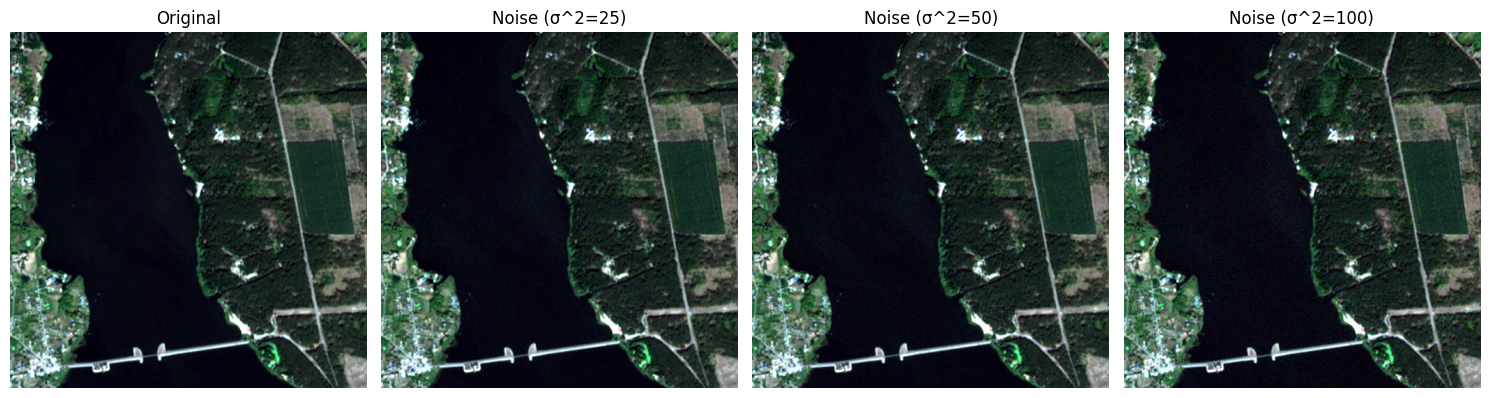


PSNR values for noisy images:
Noise (σ=25): PSNR=34.43 dB
Noise (σ=50): PSNR=31.58 dB
Noise (σ=100): PSNR=28.73 dB
Grayscale PSNR values: [38.00551939362705, 35.193835255410534, 32.32596152363945]
-------------------------------------------------------
Analyzing BPG compression for noisy images...
Processing noisy image on the server for sigma=25, quality=1...
Checking for input file on the server: /home/max/Documents/noisy_sigma_25_img_1.bmp
Converting BMP to PNG on server: /home/max/Documents/noisy_sigma_25_img_1.bmp -> /home/max/Documents/noisy_sigma_25_img_1.png
Convert Output: 
Checking for converted PNG: /home/max/Documents/noisy_sigma_25_img_1.png
PNG file found on server: /home/max/Documents/noisy_sigma_25_img_1.png
Compressing PNG to BPG: /home/max/Documents/noisy_sigma_25_img_1.png -> /home/max/Documents/compressed_q1_sigma_25_img_1.bpg
Decompressing BPG to PNG: /home/max/Documents/compressed_q1_sigma_25_img_1.bpg -> /home/max/Documents/decompressed_q1_sigma_25_img_1.png
Pro

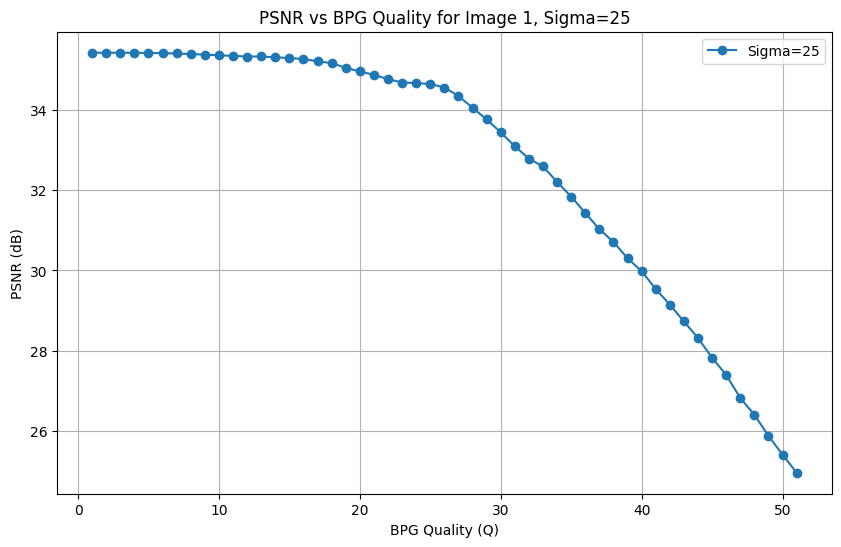

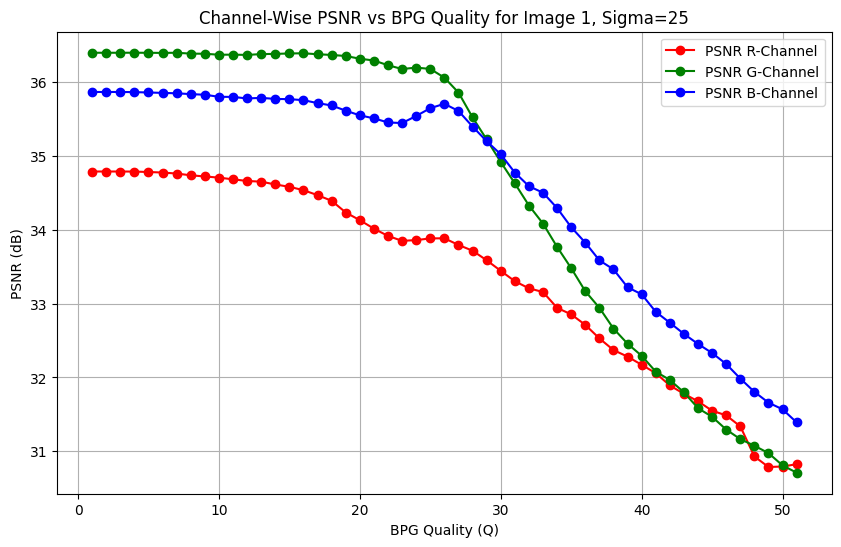

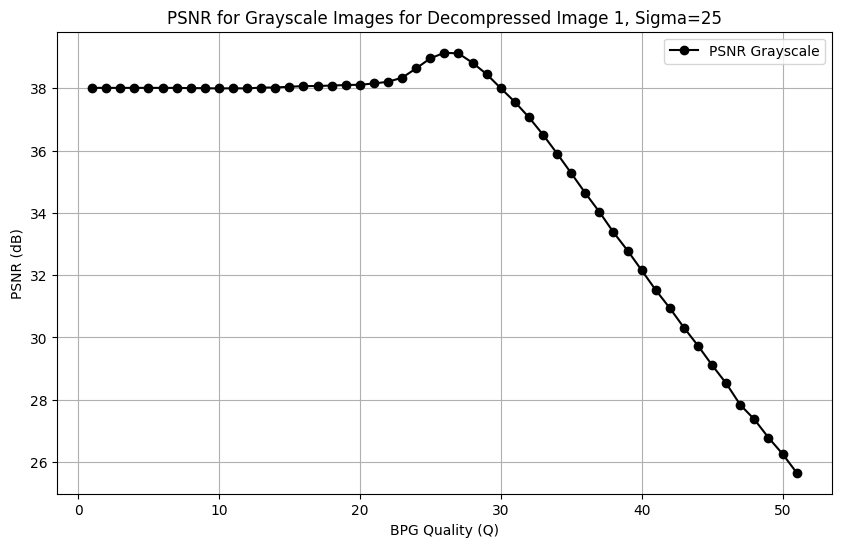

Processing noisy image on the server for sigma=50, quality=1...
Checking for input file on the server: /home/max/Documents/noisy_sigma_50_img_1.bmp
Converting BMP to PNG on server: /home/max/Documents/noisy_sigma_50_img_1.bmp -> /home/max/Documents/noisy_sigma_50_img_1.png
Convert Output: 
Checking for converted PNG: /home/max/Documents/noisy_sigma_50_img_1.png
PNG file found on server: /home/max/Documents/noisy_sigma_50_img_1.png
Compressing PNG to BPG: /home/max/Documents/noisy_sigma_50_img_1.png -> /home/max/Documents/compressed_q1_sigma_50_img_1.bpg
Decompressing BPG to PNG: /home/max/Documents/compressed_q1_sigma_50_img_1.bpg -> /home/max/Documents/decompressed_q1_sigma_50_img_1.png
Processing noisy image on the server for sigma=50, quality=2...
Checking for input file on the server: /home/max/Documents/noisy_sigma_50_img_1.bmp
Converting BMP to PNG on server: /home/max/Documents/noisy_sigma_50_img_1.bmp -> /home/max/Documents/noisy_sigma_50_img_1.png
Convert Output: 
Checking for

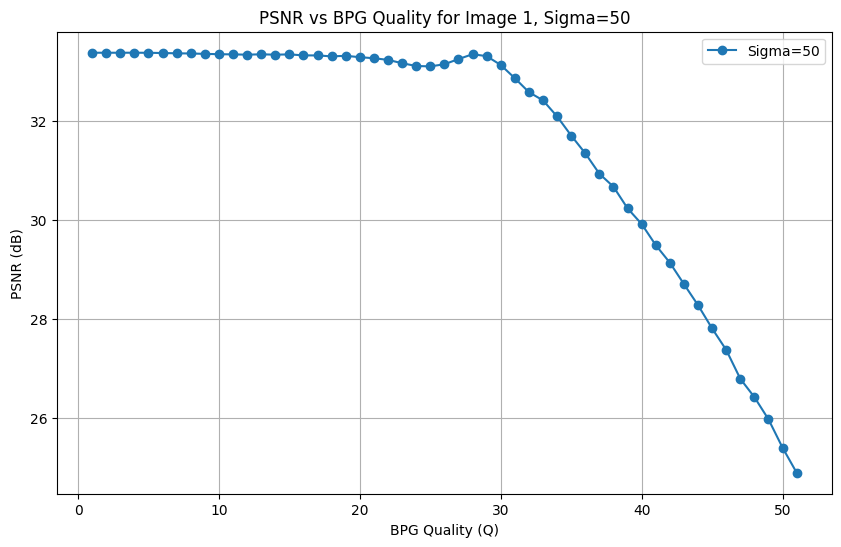

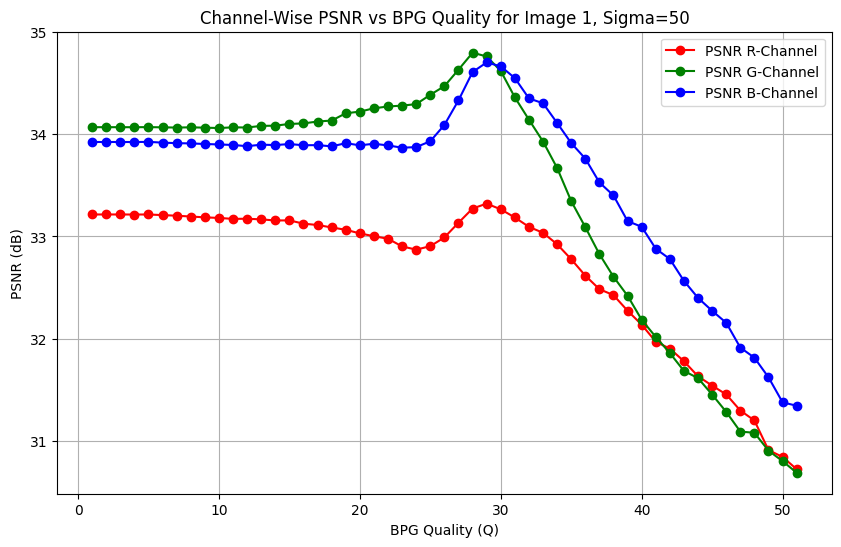

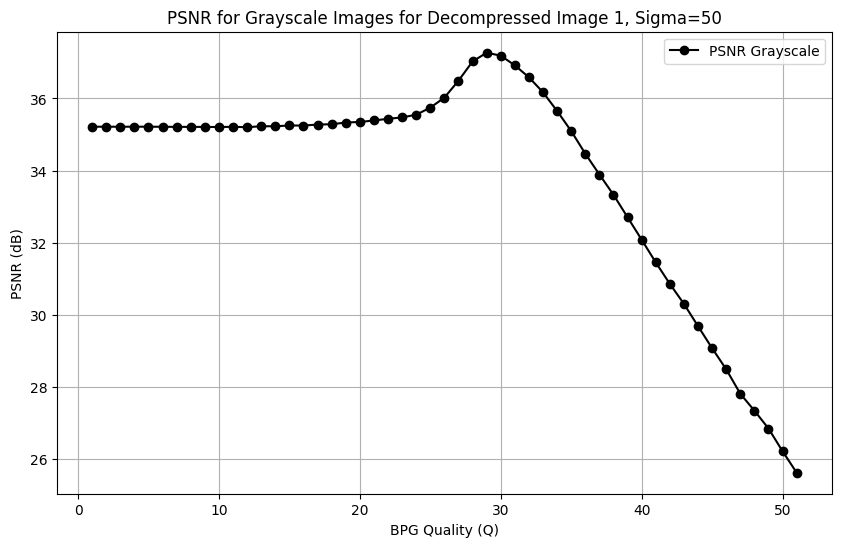

Processing noisy image on the server for sigma=100, quality=1...
Checking for input file on the server: /home/max/Documents/noisy_sigma_100_img_1.bmp
Converting BMP to PNG on server: /home/max/Documents/noisy_sigma_100_img_1.bmp -> /home/max/Documents/noisy_sigma_100_img_1.png
Convert Output: 
Checking for converted PNG: /home/max/Documents/noisy_sigma_100_img_1.png
PNG file found on server: /home/max/Documents/noisy_sigma_100_img_1.png
Compressing PNG to BPG: /home/max/Documents/noisy_sigma_100_img_1.png -> /home/max/Documents/compressed_q1_sigma_100_img_1.bpg
Decompressing BPG to PNG: /home/max/Documents/compressed_q1_sigma_100_img_1.bpg -> /home/max/Documents/decompressed_q1_sigma_100_img_1.png
Processing noisy image on the server for sigma=100, quality=2...
Checking for input file on the server: /home/max/Documents/noisy_sigma_100_img_1.bmp
Converting BMP to PNG on server: /home/max/Documents/noisy_sigma_100_img_1.bmp -> /home/max/Documents/noisy_sigma_100_img_1.png
Convert Output:

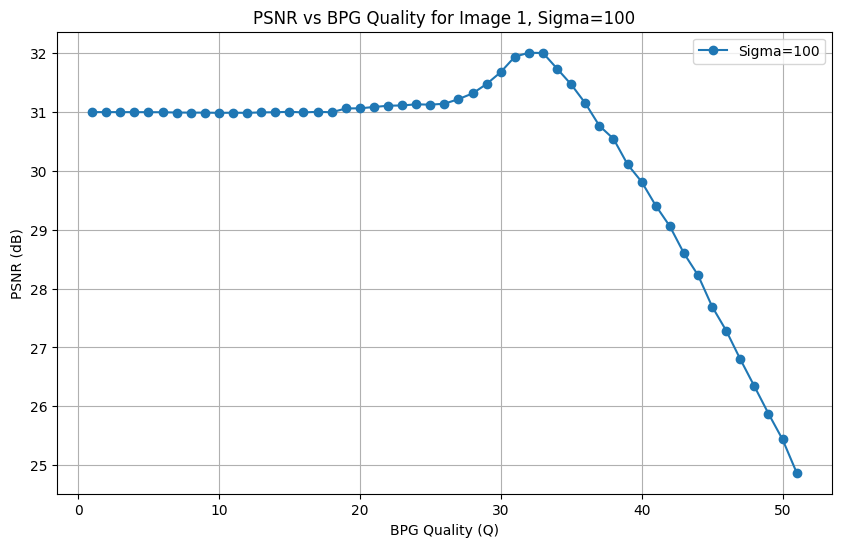

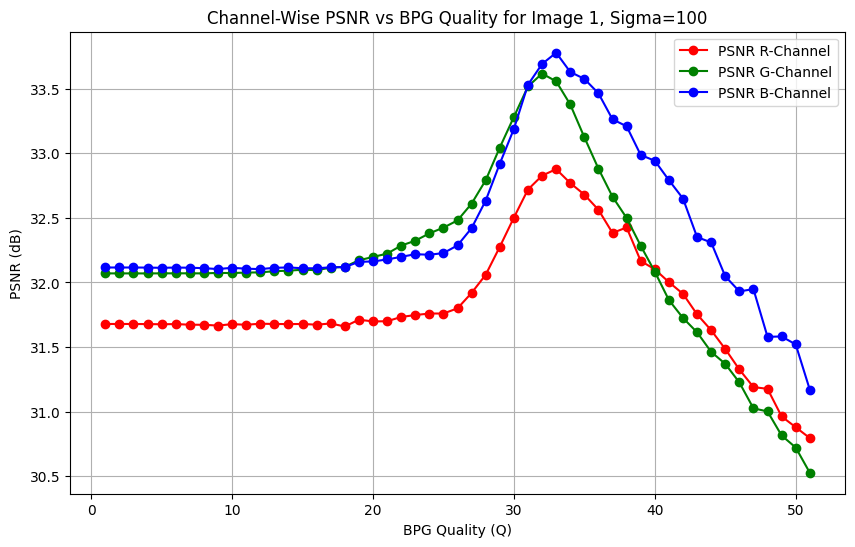

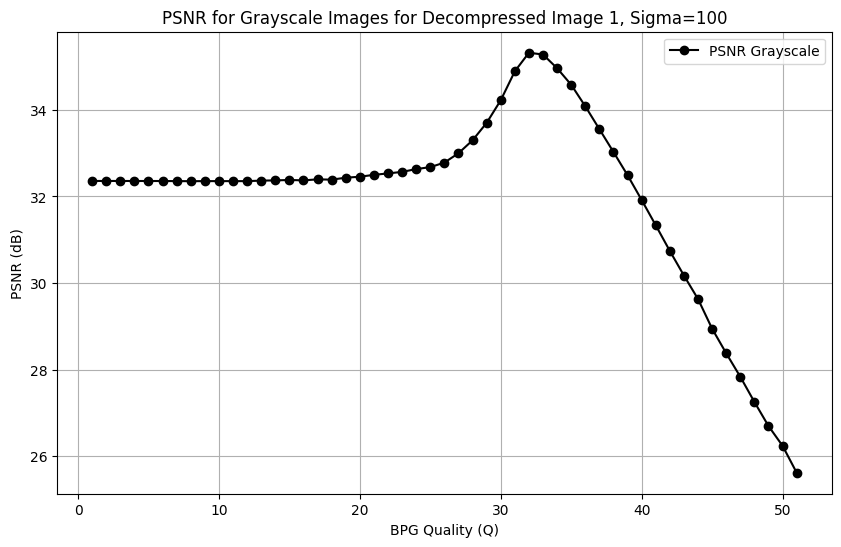

Results for image 2:
-------------------------------------------------------
Adding noise with sigma=25...
Running verification checks for noisy image (σ=25)...
Uploading noisy image to server: /home/max/Documents/noisy_sigma_25_img_2.bmp...
Uploading /Users/Maksym_Rybnytskyi/Documents/UTMShare/noisy_sigma_25_img_2.bmp to /home/max/Documents/noisy_sigma_25_img_2.bmp on server...
Adding noise with sigma=50...
Running verification checks for noisy image (σ=50)...
Uploading noisy image to server: /home/max/Documents/noisy_sigma_50_img_2.bmp...
Uploading /Users/Maksym_Rybnytskyi/Documents/UTMShare/noisy_sigma_50_img_2.bmp to /home/max/Documents/noisy_sigma_50_img_2.bmp on server...
Adding noise with sigma=100...
Running verification checks for noisy image (σ=100)...
Uploading noisy image to server: /home/max/Documents/noisy_sigma_100_img_2.bmp...
Uploading /Users/Maksym_Rybnytskyi/Documents/UTMShare/noisy_sigma_100_img_2.bmp to /home/max/Documents/noisy_sigma_100_img_2.bmp on server...


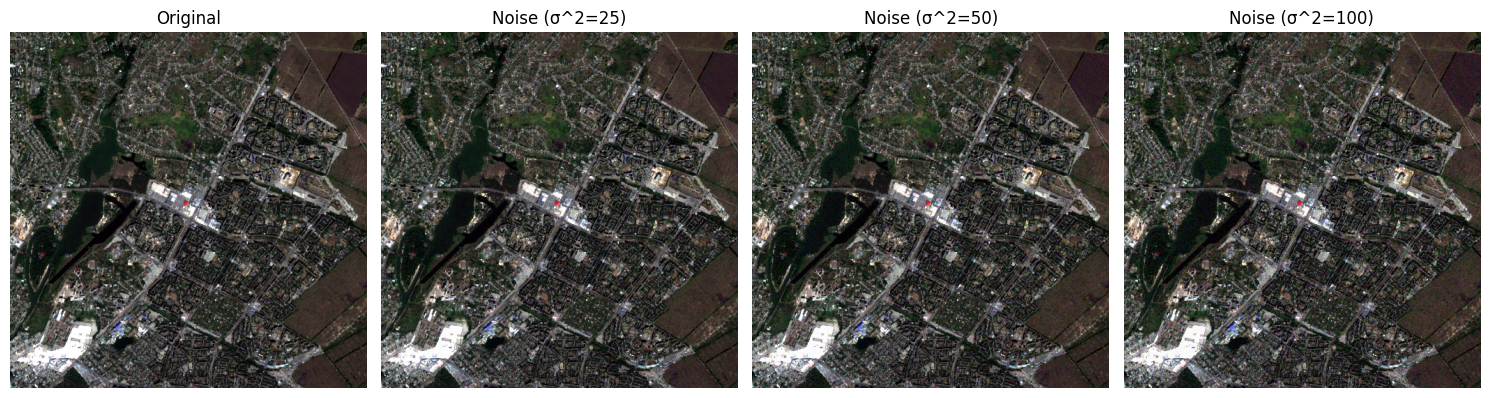


PSNR values for noisy images:
Noise (σ=25): PSNR=34.16 dB
Noise (σ=50): PSNR=31.21 dB
Noise (σ=100): PSNR=28.25 dB
Grayscale PSNR values: [37.55626616242124, 34.644215090774885, 31.701371176890454]
-------------------------------------------------------
Analyzing BPG compression for noisy images...
Processing noisy image on the server for sigma=25, quality=1...
Checking for input file on the server: /home/max/Documents/noisy_sigma_25_img_2.bmp
Converting BMP to PNG on server: /home/max/Documents/noisy_sigma_25_img_2.bmp -> /home/max/Documents/noisy_sigma_25_img_2.png
Convert Output: 
Checking for converted PNG: /home/max/Documents/noisy_sigma_25_img_2.png
PNG file found on server: /home/max/Documents/noisy_sigma_25_img_2.png
Compressing PNG to BPG: /home/max/Documents/noisy_sigma_25_img_2.png -> /home/max/Documents/compressed_q1_sigma_25_img_2.bpg
Decompressing BPG to PNG: /home/max/Documents/compressed_q1_sigma_25_img_2.bpg -> /home/max/Documents/decompressed_q1_sigma_25_img_2.png
Pr

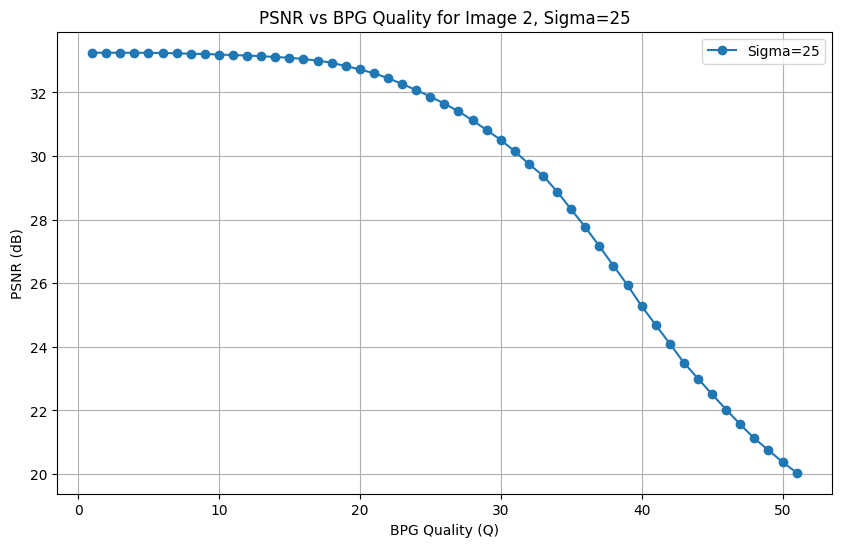

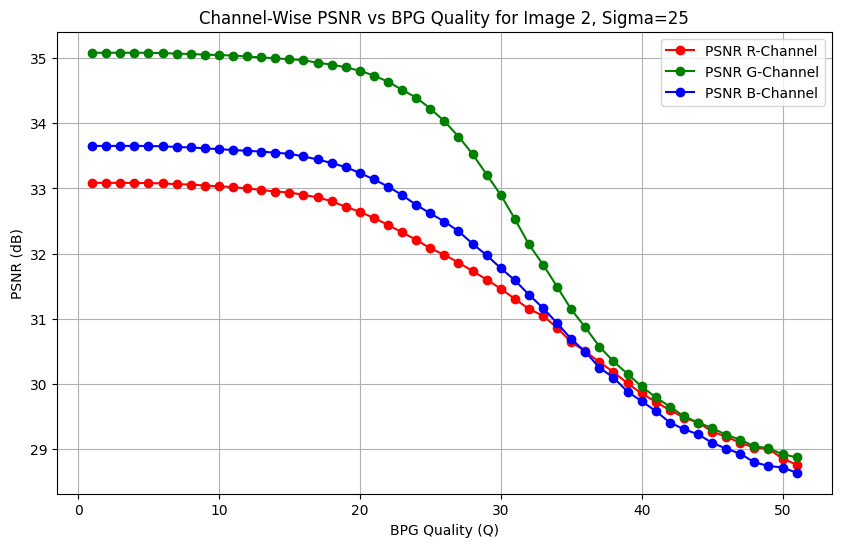

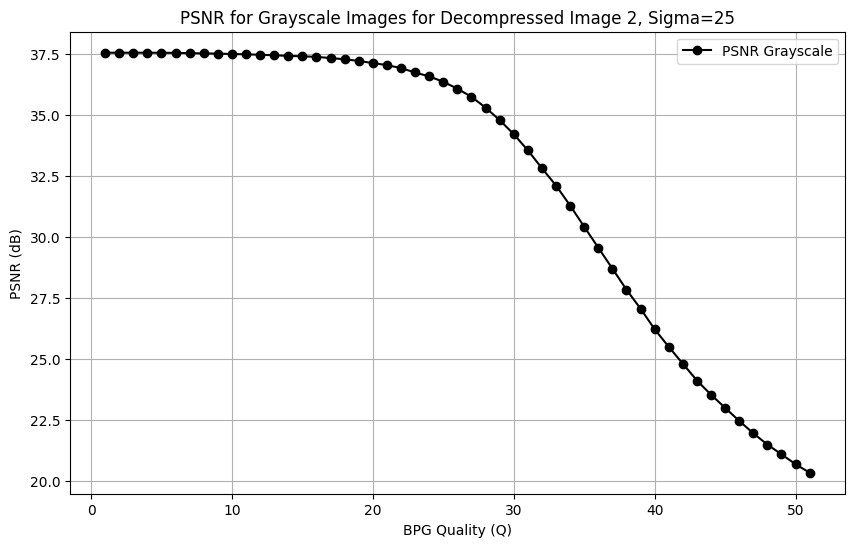

Processing noisy image on the server for sigma=50, quality=1...
Checking for input file on the server: /home/max/Documents/noisy_sigma_50_img_2.bmp
Converting BMP to PNG on server: /home/max/Documents/noisy_sigma_50_img_2.bmp -> /home/max/Documents/noisy_sigma_50_img_2.png
Convert Output: 
Checking for converted PNG: /home/max/Documents/noisy_sigma_50_img_2.png
PNG file found on server: /home/max/Documents/noisy_sigma_50_img_2.png
Compressing PNG to BPG: /home/max/Documents/noisy_sigma_50_img_2.png -> /home/max/Documents/compressed_q1_sigma_50_img_2.bpg
Decompressing BPG to PNG: /home/max/Documents/compressed_q1_sigma_50_img_2.bpg -> /home/max/Documents/decompressed_q1_sigma_50_img_2.png
Processing noisy image on the server for sigma=50, quality=2...
Checking for input file on the server: /home/max/Documents/noisy_sigma_50_img_2.bmp
Converting BMP to PNG on server: /home/max/Documents/noisy_sigma_50_img_2.bmp -> /home/max/Documents/noisy_sigma_50_img_2.png
Convert Output: 
Checking for

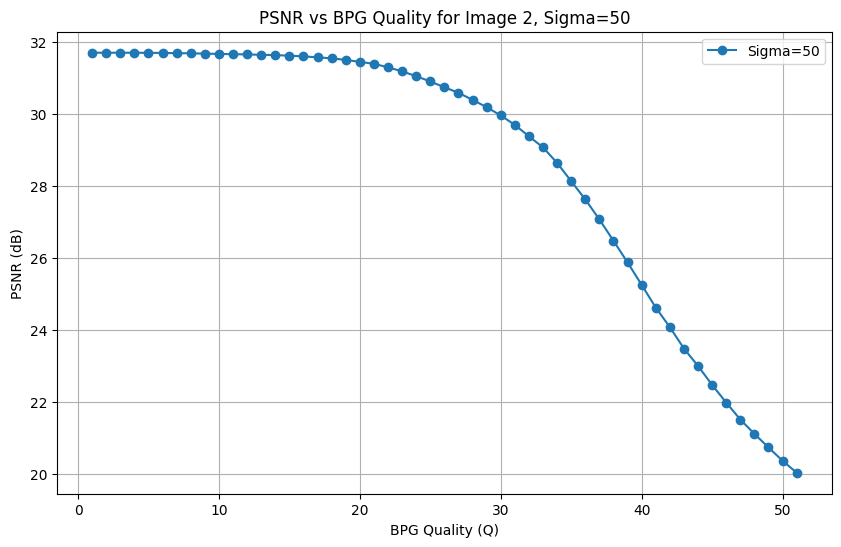

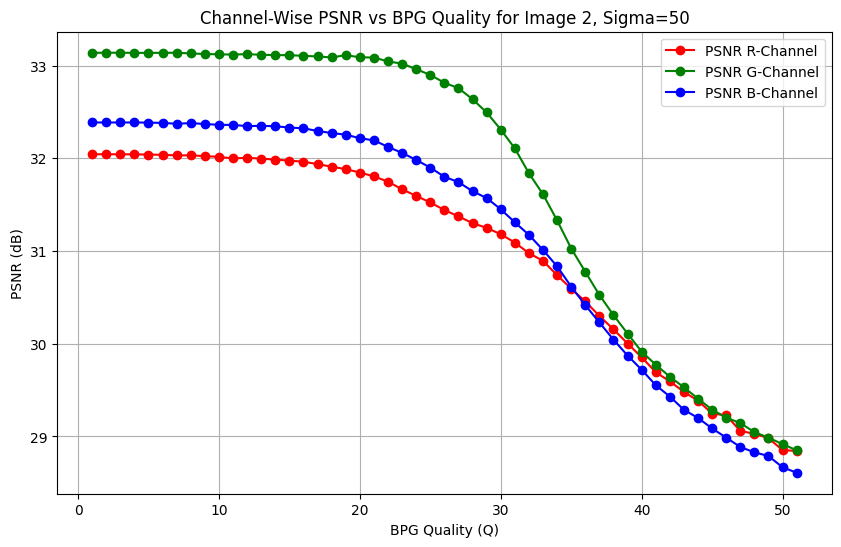

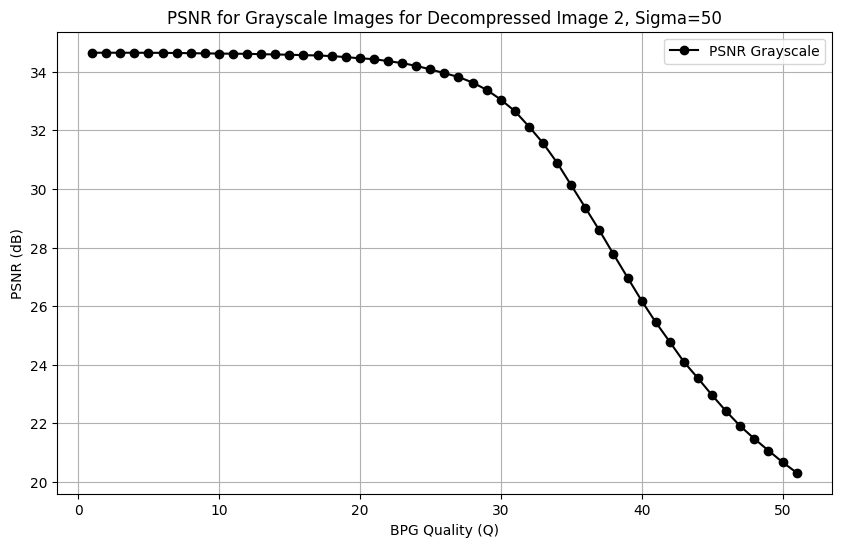

Processing noisy image on the server for sigma=100, quality=1...
Checking for input file on the server: /home/max/Documents/noisy_sigma_100_img_2.bmp
Converting BMP to PNG on server: /home/max/Documents/noisy_sigma_100_img_2.bmp -> /home/max/Documents/noisy_sigma_100_img_2.png
Convert Output: 
Checking for converted PNG: /home/max/Documents/noisy_sigma_100_img_2.png
PNG file found on server: /home/max/Documents/noisy_sigma_100_img_2.png
Compressing PNG to BPG: /home/max/Documents/noisy_sigma_100_img_2.png -> /home/max/Documents/compressed_q1_sigma_100_img_2.bpg
Decompressing BPG to PNG: /home/max/Documents/compressed_q1_sigma_100_img_2.bpg -> /home/max/Documents/decompressed_q1_sigma_100_img_2.png
Processing noisy image on the server for sigma=100, quality=2...
Checking for input file on the server: /home/max/Documents/noisy_sigma_100_img_2.bmp
Converting BMP to PNG on server: /home/max/Documents/noisy_sigma_100_img_2.bmp -> /home/max/Documents/noisy_sigma_100_img_2.png
Convert Output:

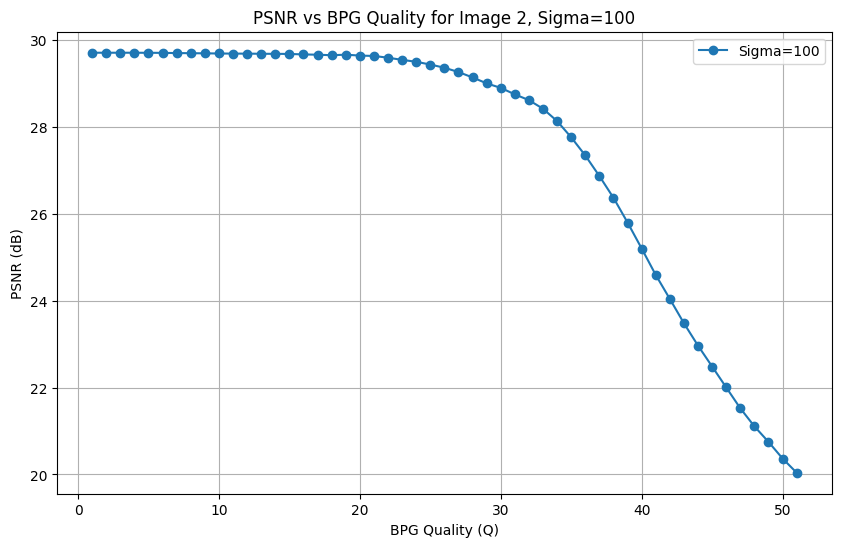

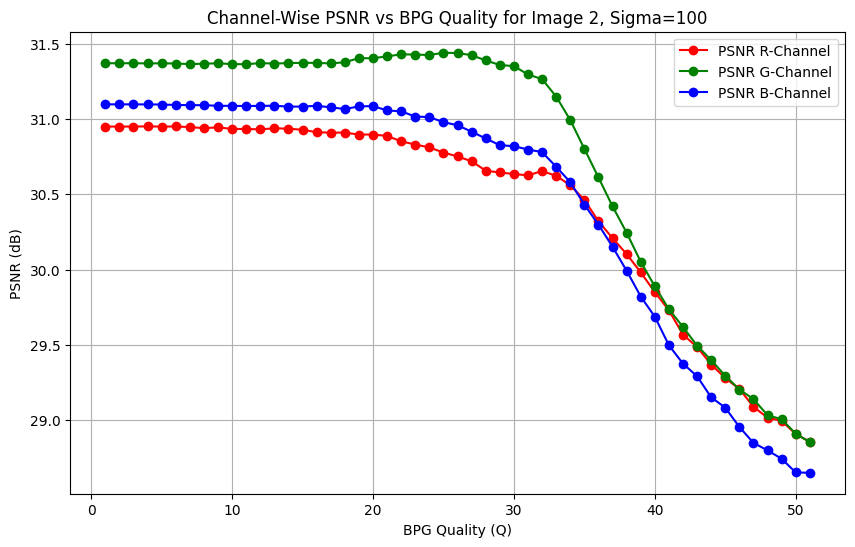

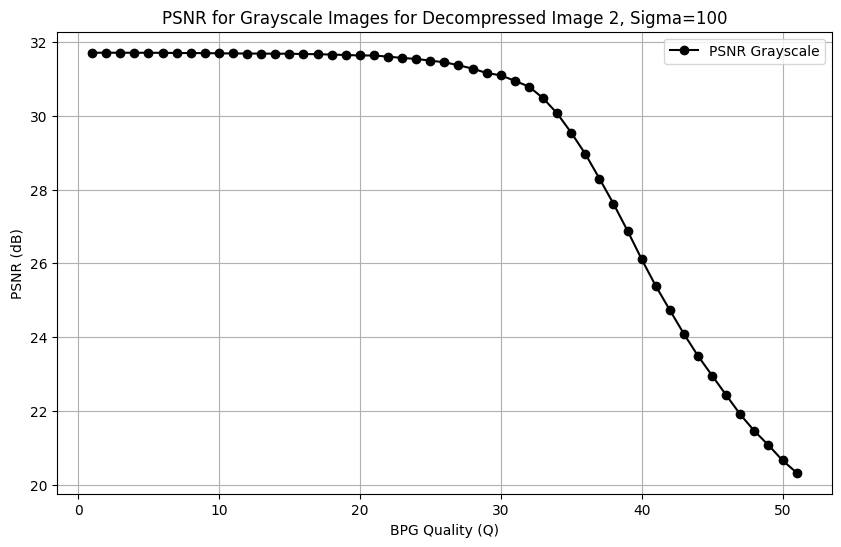

In [28]:
if __name__ == "__main__":
    import os
    import matplotlib.pyplot as plt

    # Paths for shared folders
    local_shared_folder = "/Users/Maksym_Rybnytskyi/Documents/UTMShare"  # Local path on MacBook
    server_shared_folder = "/home/max/Documents"  # Server path on Linux

    # Server details
    server_ip = "192.168.240.97"
    username = "max"
    password = "letmein"

    # Paths for two images (BMP files)
    image1_path_local = os.path.join(local_shared_folder, "SS1.bmp")
    image2_path_local = os.path.join(local_shared_folder, "SS2.bmp")
    image1_path_server = os.path.join(server_shared_folder, "SS1.bmp")
    image2_path_server = os.path.join(server_shared_folder, "SS2.bmp")

    # Upload clean BMP images to the server
    print(f"Uploading {image1_path_local} to server at {image1_path_server}...")
    upload_to_server(image1_path_local, image1_path_server, server_ip, username, password)
    print(f"Uploading {image2_path_local} to server at {image2_path_server}...")
    upload_to_server(image2_path_local, image2_path_server, server_ip, username, password)

    # List of images for processing
    images = [(image1_path_local, image1_path_server), (image2_path_local, image2_path_server)]
    sigmas = [25, 50, 100]  # Noise sigma values
    q_values = range(1, 52)  # Quality values for BPG compression

    # Part 1: Noise addition and PSNR calculation for noisy images
    for idx, (image_path_local, image_path_server) in enumerate(images):
        print(f"Results for image {idx + 1}:")
        print("-------------------------------------------------------")

        # Original image on the local machine
        original_image = cv2.imread(image_path_local, cv2.IMREAD_COLOR)
        results = [original_image]  # Start with the original image
        titles = ["Original"]       # Titles for display

        # Add noise for each sigma value
        noisy_images = {}  # Dictionary to store noisy images for each sigma
        psnr_noise_results = []  # Store PSNR values between original and noisy images
        psnr_channel_results = {'R': [], 'G': [], 'B': []}  # Поканальний PSNR для графіка
        psnr_grayscale_results = []  # PSNR для grayscale
        for sigma in sigmas:
            print(f"Adding noise with sigma={sigma}...")
            # Add noise to the image
            noisy_image = add_awgn_noise(original_image, sigma)
            noisy_images[sigma] = noisy_image  # Store the noisy image locally
            
            # Logging verification checks
            print(f"Running verification checks for noisy image (σ={sigma})...")
            if original_image.shape != noisy_image.shape:
                print("Warning: Sizes of original and noisy images do not match!")

            # Calculate PSNR between the original and noisy image (RGB + grayscale)
            psnr = calculate_psnr(original_image, noisy_image)
            psnr_channel = calculate_psnr_per_channel(original_image, noisy_image)
            psnr_grayscale = calculate_psnr_grayscale(original_image, noisy_image)
            psnr_noise_results.append((sigma, psnr))  # Store sigma and PSNR
            psnr_grayscale_results.append(psnr_grayscale)

            # Зберігаємо поканальний PSNR для кожного sigma
            psnr_channel_results['R'].append(psnr_channel['R'])
            psnr_channel_results['G'].append(psnr_channel['G'])
            psnr_channel_results['B'].append(psnr_channel['B'])
            
            # Save the noisy image locally
            noisy_image_filename = f"noisy_sigma_{sigma}_img_{idx + 1}.bmp"
            noisy_image_path_local = os.path.join(local_shared_folder, noisy_image_filename)
            noisy_image_path_server = os.path.join(server_shared_folder, noisy_image_filename)
            cv2.imwrite(noisy_image_path_local, noisy_image)

            # Add the noisy image to the result list for visualization
            results.append(noisy_image)
            titles.append(f"Noise (σ^2={sigma})")

            # Logging noisy image upload
            print(f"Uploading noisy image to server: {noisy_image_path_server}...")
            upload_to_server(noisy_image_path_local, noisy_image_path_server, server_ip, username, password)

        # Display all noisy results for the current image
        display_multiple_images(results, titles)

        # Display PSNR for noisy images in the console
        print("\nPSNR values for noisy images:")
        for sigma, psnr in psnr_noise_results:
            print(f"Noise (σ={sigma}): PSNR={psnr:.2f} dB")
        print(f"Grayscale PSNR values: {psnr_grayscale_results}")
        print("-------------------------------------------------------")

        # Part 2: BPG compression and PSNR analysis
        print("Analyzing BPG compression for noisy images...")
        for sigma, noisy_image in noisy_images.items():
            psnr_bpg_results = []  # Загальні PSNR значення (цілого зображення) для поточного sigma
            psnr_bpg_channel_results = {'R': [], 'G': [], 'B': []}  # Поканальні значення PSNR
            psnr_bpg_grayscale_results = []  # PSNR для grayscale
        
            # Compress and decompress using BPG for each quality level
            for q in q_values:
                # Correctly define the paths for the current noisy image
                noisy_image_filename = f"noisy_sigma_{sigma}_img_{idx + 1}.bmp"
                noisy_image_path_server = os.path.join(server_shared_folder, noisy_image_filename)  # Correctly construct the server path
        
                compressed_bpg_path = os.path.join(server_shared_folder, f"compressed_q{q}_sigma_{sigma}_img_{idx + 1}.bpg")
                decompressed_png_path = os.path.join(server_shared_folder, f"decompressed_q{q}_sigma_{sigma}_img_{idx + 1}.png")
        
                try:
                    # Call run_bpg_on_server to perform compression and decompression
                    print(f"Processing noisy image on the server for sigma={sigma}, quality={q}...")
                    run_bpg_on_server(
                        noisy_image_path_server,  # Input noisy image on the server
                        compressed_bpg_path,     # Path to the compressed BPG file
                        decompressed_png_path,   # Path to the decompressed PNG file
                        q,                       # Compression quality parameter (Q)
                        server_ip,
                        username,
                        password
                    )
        
                    # Check decompressed image exists locally and load it
                    decompressed_image_filename = f"decompressed_q{q}_sigma_{sigma}_img_{idx + 1}.png"
                    decompressed_image_path_local = os.path.join(local_shared_folder, decompressed_image_filename)
                    download_from_server(decompressed_png_path, decompressed_image_path_local, server_ip, username, password)
                    decompressed_image = cv2.imread(decompressed_image_path_local, cv2.IMREAD_COLOR)
        
                    # Verification checks
                    if original_image.shape != decompressed_image.shape:
                        print("Warning: Sizes of original and decompressed images do not match!")
                    # compare_channel_order(original_image, noisy_image)
                    # check_channel_correlation(original_image, decompressed_image)
                    
                    # Calculate PSNR between original image and decompressed image
                    psnr_bpg = calculate_psnr(original_image, decompressed_image)
                    psnr_channel_bpg = calculate_psnr_per_channel(original_image, decompressed_image)
                    psnr_grayscale_bpg = calculate_psnr_grayscale(original_image, decompressed_image)
                    psnr_bpg_results.append(psnr_bpg)
                    psnr_bpg_grayscale_results.append(psnr_grayscale_bpg)
        
                    # Зберігаємо поканальний PSNR для кожного Q
                    psnr_bpg_channel_results['R'].append(psnr_channel_bpg['R'])
                    psnr_bpg_channel_results['G'].append(psnr_channel_bpg['G'])
                    psnr_bpg_channel_results['B'].append(psnr_channel_bpg['B'])
        
                except Exception as e:
                    print(f"Error for Q={q}, Sigma={sigma}: {e}")
                    psnr_bpg_results.append(None)
                    psnr_bpg_channel_results['R'].append(None)
                    psnr_bpg_channel_results['G'].append(None)
                    psnr_bpg_channel_results['B'].append(None)
                    psnr_bpg_grayscale_results.append(None)
                    continue
        
            # Plot PSNR(Q) graph for the current sigma (загальний PSNR)
            plt.figure(figsize=(10, 6))
            plt.plot(q_values, psnr_bpg_results, marker='o', label=f"Sigma={sigma}")
            plt.title(f"PSNR vs BPG Quality for Image {idx + 1}, Sigma={sigma}")
            plt.xlabel("BPG Quality (Q)")
            plt.ylabel("PSNR (dB)")
            plt.grid(True)
            plt.legend()
            plt.show()
        
            # Plot channel-wise PSNR(Q) graph for the current sigma (поканальний PSNR)
            plt.figure(figsize=(10, 6))
            plt.plot(q_values, psnr_bpg_channel_results['R'], marker='o', label="PSNR R-Channel", color='red')
            plt.plot(q_values, psnr_bpg_channel_results['G'], marker='o', label="PSNR G-Channel", color='green')
            plt.plot(q_values, psnr_bpg_channel_results['B'], marker='o', label="PSNR B-Channel", color='blue')
            plt.title(f"Channel-Wise PSNR vs BPG Quality for Image {idx + 1}, Sigma={sigma}")
            plt.xlabel("BPG Quality (Q)")
            plt.ylabel("PSNR (dB)")
            plt.grid(True)
            plt.legend()
            plt.show()
        
            # Plot PSNR for Grayscale Images (BPG)
            plt.figure(figsize=(10, 6))
            plt.plot(q_values, psnr_bpg_grayscale_results, marker='o', label="PSNR Grayscale", color='black')
            plt.title(f"PSNR for Grayscale Images for Decompressed Image {idx + 1}, Sigma={sigma}")
            plt.xlabel("BPG Quality (Q)")
            plt.ylabel("PSNR (dB)")
            plt.grid(True)
            plt.legend()
            plt.show()
               

# What's Next?

1. Analyse results and define OOP for SS1 and SS2.
2. Prepare images in advance. I can add this code here to store all images with required names in specified folder.
3. Extend functionality of LBP+Color+XGBoost per-pixel Sentinel.ipynb notebook and add additional function that will train and classify in cycle using provided images. 